# Kriging Missing/Corrupted Pixels in Images

In this code demo I take you through simple (but not necessarily fast!) kriging methods for restoring images with corrupted or missing pixels. SciKit-Learn and SciKit-Image are our main tools here. We use a synthetically-corrupted example image borrowed from the demo at https://scikit-image.org/docs/stable/auto_examples/filters/plot_inpaint.html, with a few small modifications. 

In the future, I'd like to use the techniques built here to learn how to deal with partial cloud cover in VNIR satellite images (for instance, following https://www.sciencedirect.com/science/article/pii/S1569843223000584, https://www.coastalwiki.org/wiki/Interpolation_of_remote_sensing_images, or https://www.sciencedirect.com/science/article/abs/pii/0034425794900574). 

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import time

# this makes sure the images don't come out looking muddy on 
# retina displays (which your computer probably uses)
%config InlineBackend.figure_format='retina'

# set textcolor in images 
textcolor='k'

# Finally, print nice Latex labels for figures. 
# Comment these out if you don't want to wait for the tex to compile, or don't
# want to bother get tex working. 
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# also, we should manually set the dpi for figures so they look good
# if saving figs, you should do so at a much higher dpi!
dpi = 300

## Setup + Restoration via Inpainting

This closely follows the SciKit-Image tutorial referenced above, with minor changes made to accomodate using a grayscale image. First, we import the stuff we need. 

In [2]:
from skimage import data
from skimage.color import rgb2gray
from skimage.morphology import disk, binary_dilation
from skimage.restoration import inpaint

Now we import the image and convert it to grayscale.

In [3]:
image_orig = rgb2gray(data.astronaut())

Next, corrupt the image by creating a mask of pixels to replace with black. This is nearly identical to the SciKit-Image tutorial, but I've also added some corruption to the eye area in  the picture. This in turn makes the "fix" from our restoration really pop. 

In [4]:
# Create mask with six block defect regions
mask = np.zeros(image_orig.shape, dtype=bool)
#"""
mask[20:60, 0:20] = 1
mask[160:180, 70:155] = 1
mask[30:60, 170:195] = 1
mask[-60:-30, 170:195] = 1
mask[-180:-160, 70:155] = 1
mask[-60:-20, 0:20] = 1

# Add a few long, narrow defects
mask[200:205, -200:] = 1
mask[150:255, 20:23] = 1
mask[365:368, 60:130] = 1
mask[102:106, 240:260] = 1 # AM: I added this to the demo bcz it overlays the astronaut's left eye, so the errors from this bar 
# are much more noticeable in the image
#"""

#"""
# Add randomly positioned small point-like defects
rstate = np.random.default_rng(0)
for radius in [0, 2, 4]:
    # larger defects are less common
    thresh = 3 + 0.25 * radius  # make larger defects less common
    tmp_mask = rstate.standard_normal(image_orig.shape) > thresh
    if radius > 0:
        tmp_mask = binary_dilation(tmp_mask, disk(radius, dtype=bool))
    mask[tmp_mask] = 1
#"""
# Apply defect mask to the image
image_defect = image_orig * ~mask

Before talking about kriging, let's see how the (PDE-based) inpainting tools in SciKit-Image do. 

In [5]:
image_result = inpaint.inpaint_biharmonic(image_defect, mask)

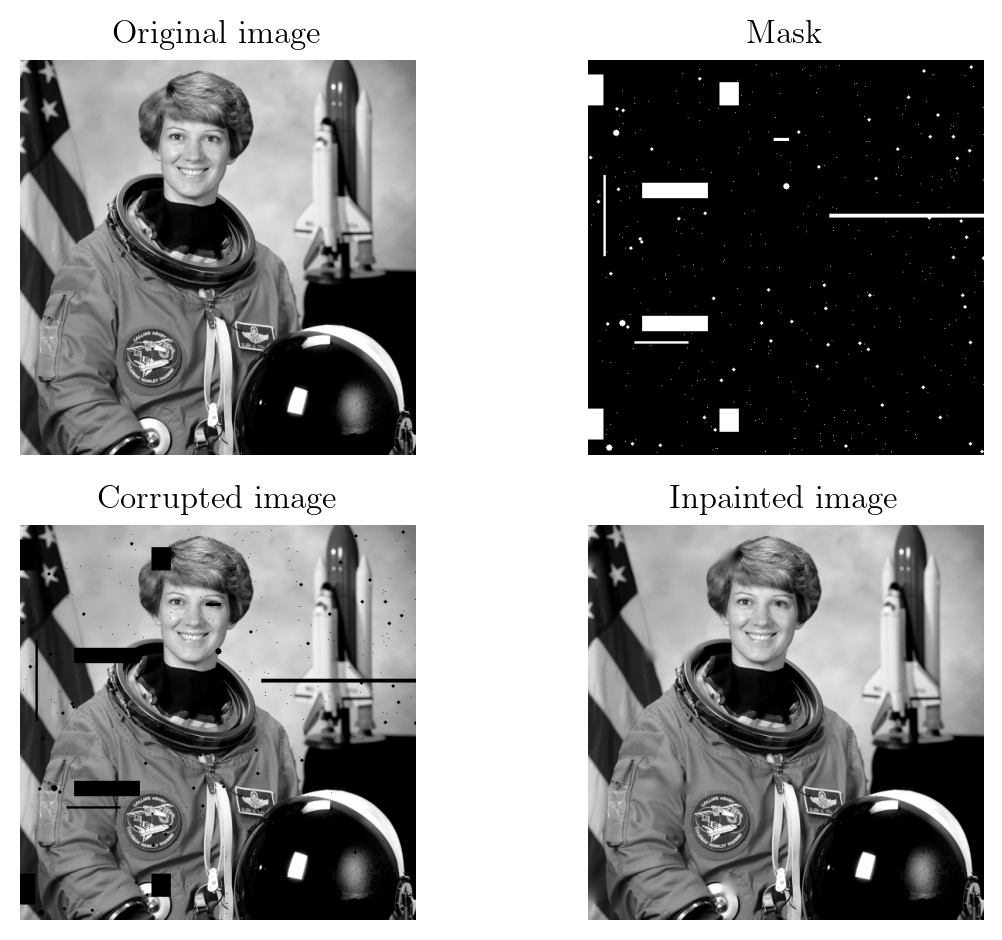

In [6]:
fig, axes = plt.subplots(ncols=2, nrows=2)
ax = axes.ravel()

ax[0].set_title('Original image')
ax[0].imshow(image_orig, cmap=plt.cm.gray)

ax[1].set_title('Mask')
ax[1].imshow(mask, cmap=plt.cm.gray)

ax[2].set_title('Corrupted image')
ax[2].imshow(image_defect, cmap=plt.cm.gray)

ax[3].set_title('Inpainted image')
ax[3].imshow(image_result, cmap=plt.cm.gray)

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

Inpainting is really fast and does a pretty good job at first glance, but on closer inspection the areas it fills in are quite blurry or inaccurate (for example, the part in the astronaut's hair, her left eye, and a thin horizontal stripe just above the round mission patch on her right-hand side). We can plot the error between the ground truth and the reconstructed image to see these discrepancies more clearly: 

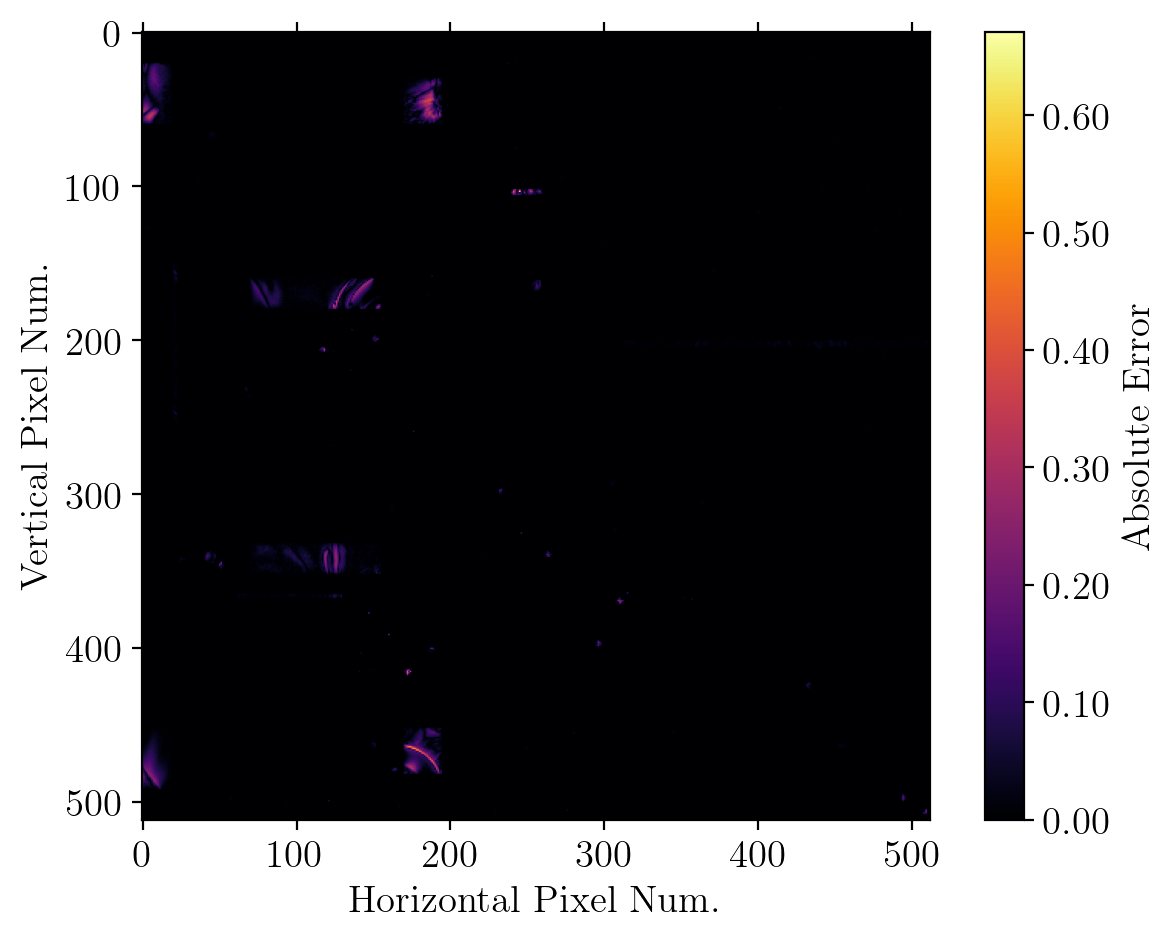

In [7]:
fig, ax = plt.subplots(ncols=1, nrows=1)

last = ax.imshow(np.abs(image_result-image_orig), cmap='inferno')

plt.xlabel(r"Horizontal Pixel Num.", fontsize=14, color = textcolor)
plt.ylabel(r"Vertical Pixel Num.", fontsize=14, color=textcolor)


plt.tick_params(axis='x', which='both', top='off', color = textcolor)
plt.xticks(fontsize=14, rotation=0, color = textcolor)
plt.yticks(fontsize=14, rotation=0, color = textcolor)

cbar = plt.colorbar(last,  format='%.2f',fraction=0.046, pad=0.05)
cbar.ax.tick_params(labelsize=14, color=textcolor) 
cbar.ax.set_ylabel(r'Absolute Error', fontsize=14, color=textcolor)
cbytick_obj = plt.getp(cbar.ax.axes, 'yticklabels')                
plt.setp(cbytick_obj, color=textcolor)

fig.tight_layout()
plt.show()

## A Naive Approach to Kriging: Using "All" the Data

Now let's try an alternative image reconstruction using kriging. In addition to giving us a "fixed" image, kriging gives us theoretical error estimates!

The main idea here is that we view the uncorrupted pixels as training/test data, or the points where the exact value of the image's random field was measure. The corrupted pixels are the points where we need to interpolate the random field. 

First, let's import all the stuff we need from SciKit-Learn (from the time series demo, this seems like the best way possible to krige!). 

In [8]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern 
from sklearn.model_selection import train_test_split

kernel = 1.*Matern(length_scale_bounds=(1e-05, 100.0), nu=0.5) # note: bcz of edges in the image I think this e^{-|x|} kernel is a good choice
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3, alpha=1e-1, normalize_y=True) # normalizn critical here!

Of course, for a hi-res image like the one we're looking at, we don't have the computing power to use every uncorrupted pixel in our training data. For a first pass at kriging, let's just take a random sample of the uncorrupted pixels as training data. By default, the code only takes $1\%$ of uncorrupted pixels into the training set and the training time is around half a minute (more or less). If this is increased to even $5\%$, the training time is around 20 minutes!  

In [9]:
# next two lines are thanks to the discussion here: https://stackoverflow.com/questions/73162794/reconstructing-image-from-mask-coordinates
good_pixels = np.flip(np.column_stack(np.where(mask == 0)), axis=1) #getting coordinates of uncorrupted pixels

good_values = image_defect[mask==0]

# do a test-train split to random sample some training data
X_train, X_test, Y_train, Y_test = train_test_split(good_pixels, good_values, train_size=0.01) # 

# getting coordinates of corrupted pixels
pred_pixels = np.flip(np.column_stack(np.where(mask > 0)), axis=1)

With the training set defined, let's get our covariance kernel. 

In [10]:
start=time.time()
gaussian_process.fit(X_train, Y_train); 
end=time.time()
naive_kriging_training_time = (end-start)/60.
print('Naive kriging training time = %.4f' % naive_kriging_training_time, 'min')

Naive kriging training time = 0.2850 min


Now, put the kriged pixel values into our image and display the result. 

In [11]:
image_kriged = image_defect.copy()

kriged_pixels, std = gaussian_process.predict(pred_pixels, return_std=True)

cnt = 0
for pixel in pred_pixels:
    image_kriged[pixel[1], pixel[0]] = kriged_pixels[cnt]
    cnt+=1

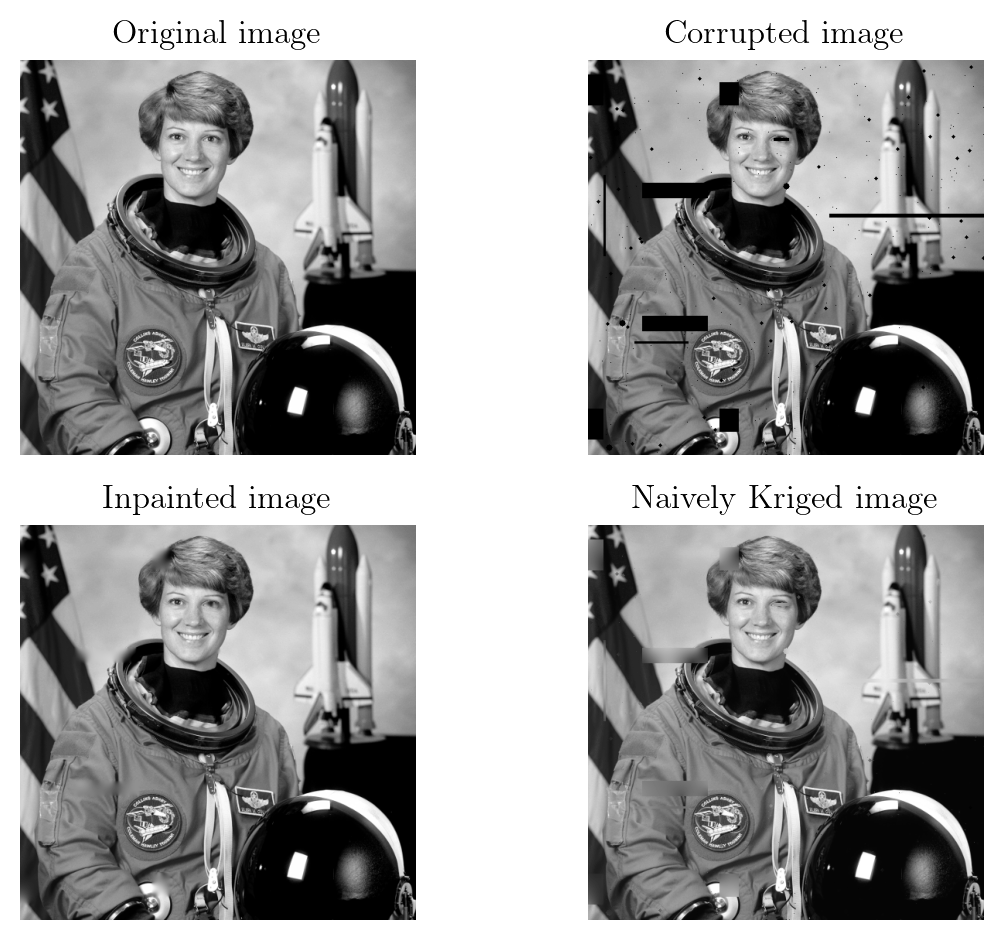

In [12]:
fig, axes = plt.subplots(ncols=2, nrows=2)
ax = axes.ravel()

ax[0].set_title('Original image')
ax[0].imshow(image_orig, cmap=plt.cm.gray)

ax[1].set_title('Corrupted image')
ax[1].imshow(image_defect, cmap=plt.cm.gray)

ax[2].set_title('Inpainted image')
ax[2].imshow(image_result, cmap=plt.cm.gray)

ax[3].set_title('Naively Kriged image')
ax[3].imshow(image_kriged, cmap=plt.cm.gray)

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

This naive approach to kriging gives pretty poor results: most of the smoothed-out "boxes" of corrupted pixels are still very noticeable. Taken together with slowness, it's looking like we'll have to krige in a smarter way. 

Before explaining an alternative, let's see how the kriging error predictions fit the actual errors computed with respect to the known original image. 

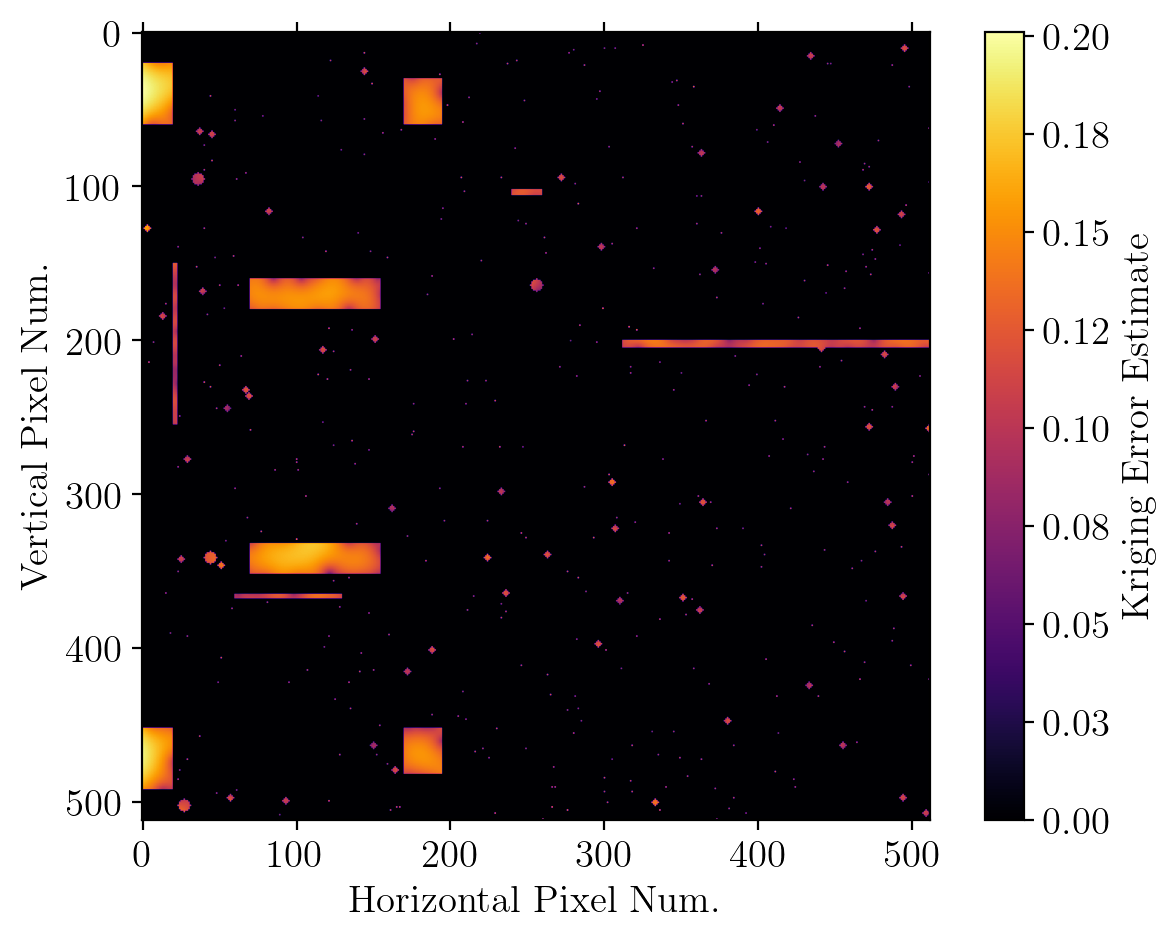

In [13]:
# plot theoretical predictions of kriging error
fig, ax = plt.subplots(ncols=1, nrows=1)

kriging_error = np.zeros_like(image_orig)

cnt = 0
for pixel in pred_pixels:
    kriging_error[pixel[1], pixel[0]] = std[cnt]
    cnt+=1

last = ax.imshow(kriging_error, cmap='inferno')

plt.xlabel(r"Horizontal Pixel Num.", fontsize=14, color = textcolor)
plt.ylabel(r"Vertical Pixel Num.", fontsize=14, color=textcolor)

plt.tick_params(axis='x', which='both', top='off', color = textcolor)
plt.xticks(fontsize=14, rotation=0, color = textcolor)
plt.yticks(fontsize=14, rotation=0, color = textcolor)

cbar = plt.colorbar(last,  format='%.2f',fraction=0.046, pad=0.05)
cbar.ax.tick_params(labelsize=14, color=textcolor) 
cbar.ax.set_ylabel(r'Kriging Error Estimate', fontsize=14, color=textcolor)
cbytick_obj = plt.getp(cbar.ax.axes, 'yticklabels')                
plt.setp(cbytick_obj, color=textcolor)

fig.tight_layout()
plt.show()

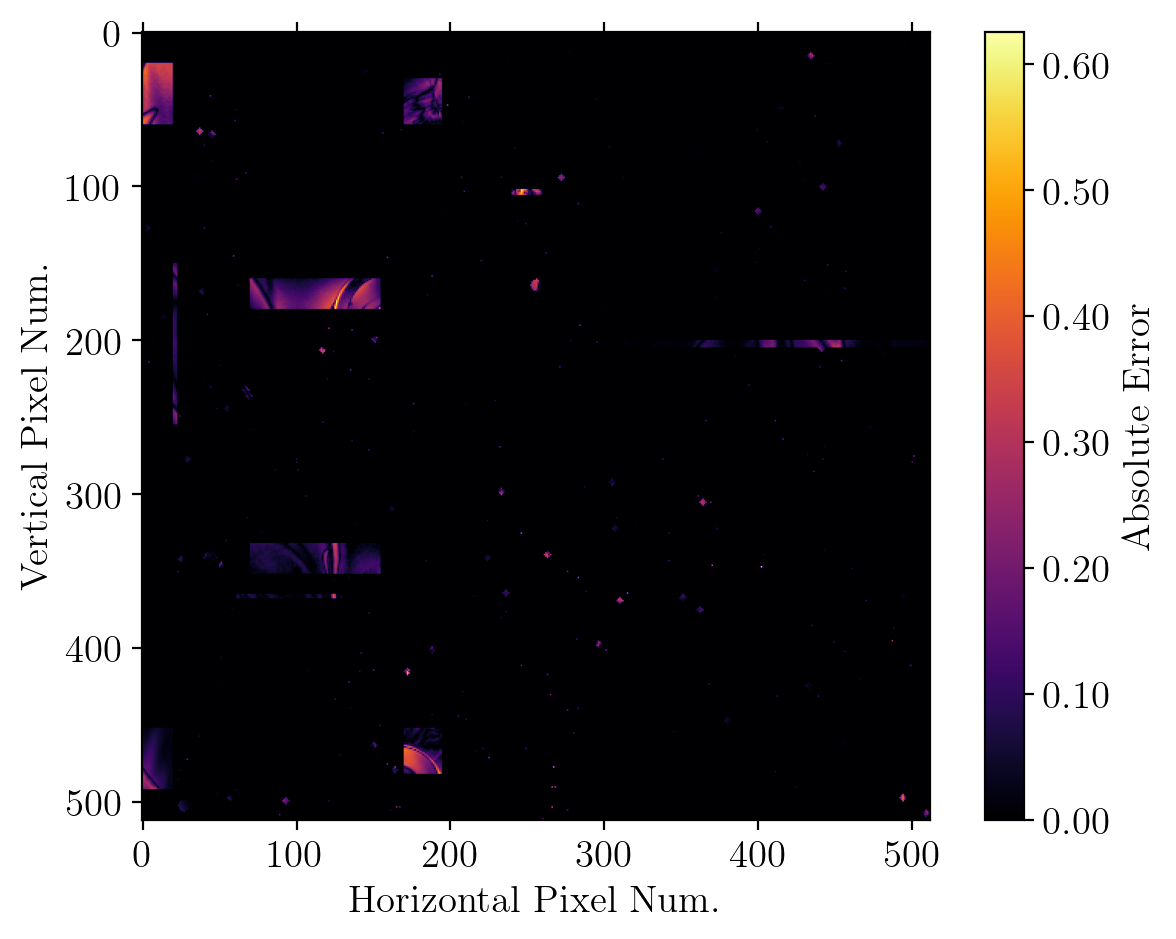

In [14]:
# plot actual kriging error
fig, ax = plt.subplots(ncols=1, nrows=1)

last = ax.imshow(np.abs(image_kriged-image_orig), cmap='inferno') #, clim=(0,0.15))

plt.xlabel(r"Horizontal Pixel Num.", fontsize=14, color = textcolor)
plt.ylabel(r"Vertical Pixel Num.", fontsize=14, color=textcolor)

plt.tick_params(axis='x', which='both', top='off', color = textcolor)
plt.xticks(fontsize=14, rotation=0, color = textcolor)
plt.yticks(fontsize=14, rotation=0, color = textcolor)

cbar = plt.colorbar(last,  format='%.2f',fraction=0.046, pad=0.05)
cbar.ax.tick_params(labelsize=14, color=textcolor) 
cbar.ax.set_ylabel(r'Absolute Error', fontsize=14, color=textcolor)
cbytick_obj = plt.getp(cbar.ax.axes, 'yticklabels')                
plt.setp(cbytick_obj, color=textcolor)

fig.tight_layout()
plt.show()

From these plots, it appears that the theoretical kriging error is typically an *underestimate*. The most error comes from edges/high frequencies in the image, such as the astronaut's left eye and the left side of her helmet collar. In a sense, this is to be expected: we know kriging is often a smoothing process, so it can't necessarily handle high frequencies well.   

# A Smarter Idea: Local Kriging

We just saw that kriging "all at once" with even a small sample of all available pixels isn't a good strategy in terms of both runtime and performance. A better approach is to use **local kriging** where the image value at each unknown pixel is estimated using only "nearby" uncorrupted pixels. In addition to breaking the fitting and prediction problem down into many much smaller problems, this approach takes manifestly takes advantage of local behaviour. 

Let $P$ be a pixel with unknown image value. In order to extract all pixels "near" $P$, which we denote by the set $\nu\left(P\right)$, we use a simple graph-based method. At "step zero", out set $\nu\left(P\right)$ is empty. Next, we identify all pixels adjacent to $P$ (generically, the pixels that lie left, right, up, or down relative to $P$) using scikit-image and networkX and add these pixels to $\nu\left(P\right).$ We then determine those pixels in $\nu\left(P\right)$ that are known/corrupted or unknown/corrupted. If the number of known pixels in $\nu\left(P\right)$ is not sufficiently large, we need to invite more neighbors to the party: we loop through all pixels $P' \in \nu\left(P\right)$ and add pixels adjacent to $P'$ to $\nu\left(P\right)$ as well, ignoring repetitions. Then, we again check if there are enough known pixels in $\nu\left(P\right)$, and the process continues iteratively. 

The parameter "balancing act" in this approach involves selecting the admissible size $n$ of $\left|\nu\left(P\right)\right|$ below which we say there aren't enough neighbors to krige. If $n$ is too large, we'll end up doing more work than is necessary, but if $n$ is too small then our fit may fail to converge or may give poor predictions. In practice, I allow for $n$ to be iteratively refined in the code below, though certain pixels are very stubborn and even for large $n$ we can't successfully train a kernel. I'll say a little more about how training failures are handled later. 

One final remark before I start: a different kernel must be trained *for each corrupted pixel*. While the training set for each problem is pretty small, that's still a lot of kernels! An alternative local approach where pixels are sorted into bunches and kernels are trained bunch-wise will likely improve performance further. 

Now for the actual code. We start by creating the pixel graph of our defected image so we can use networkX to quickly extract neighboring pixels: I don't want to write a neighbor-searching function myself if I can avoid it. 

In [15]:
from skimage.graph import pixel_graph
import networkx as nx

amat = pixel_graph(image_defect) # strictly speaking this is the adjacency matrix of the pixel graph, despite the name
pg = nx.from_scipy_sparse_array(amat[0]) # actually get pixel graph as a networkX graph object

Next we need some helper functions for switching between coordinate (on-image) and label/node (on graph) representations of a pixel. The parameter "512" arises from the resolution of our image, and for a generic code this would have to be modified based on the resolution of the image at hand. But these modifications would be simple so I won't worry about them here. 

In [16]:
def label_to_coord(node):
    out = np.zeros((2), dtype=int)
    out[1] = int(node/512)
    out[0] = node % 512
    return out

def coord_to_label(pixel):
    pixel = np.array(pixel)
    out = pixel[...,1]*512 + pixel[...,0]%512
    return np.array(out, dtype=int)

As a first application of our helper function, let's get the node labels of the masked pixels. 

In [17]:
mask_labels = coord_to_label(pred_pixels)

We also need function that takes in a pixel $P$ and outputs all coordinates of all other pixels that can be used to krige the image
intensity at $P$: this is the set $\nu\left(P\right)$ that we discussed above. 

In [18]:
def get_good_nbhrs(pixel, n = 12): # param n = minimum number of known pixels nu(P) must include 

    # get node number of pixel
    my_node = coord_to_label(pixel)
    
    # get immediate neighbours
    #nbhr_nodes = np.array(list(pg.neighbors(int(my_node))))
    nbhr_nodes = np.fromiter(pg.neighbors(int(my_node)), dtype=int)

    # determine which neighbours have known intensities 
    known_nbhr_nodes = nbhr_nodes[~np.isin(nbhr_nodes, mask_labels)]

    # if there's not enough nearby known pixels to krige, then invite more neighbors 
    while np.shape(known_nbhr_nodes)[0] < n:

        for node in nbhr_nodes:

            #nbhr_nodes = np.append(nbhr_nodes, np.array(list(pg.neighbors(node))))
            nbhr_nodes = np.append(nbhr_nodes, np.fromiter(pg.neighbors(int(node)), dtype=int))

        nbhr_nodes = np.unique(nbhr_nodes[nbhr_nodes != my_node]) # remove the repeated values and the original node

        known_nbhr_nodes = nbhr_nodes[~np.isin(nbhr_nodes, mask_labels)]

    return np.array([label_to_coord(node) for node in known_nbhr_nodes]) # issues with int() only working on scalars cascase & require a loop here

Here are some additional helper functions... 

In [19]:
def extract_training_data(pixel, n = 4):
    X_train_loc = get_good_nbhrs(pixel, n=n) # identify which nearby pixels are suitable for training

    Y_train_loc = np.array([image_defect[training_pixel[1], training_pixel[0]] for training_pixel in X_train_loc])

    return X_train_loc, Y_train_loc

def pixel_predict(pixel, gaussian_process, n=16): # fit a kernel + predict 

    X_train_loc, Y_train_loc = extract_training_data(pixel, n = n)

    gaussian_process.fit(X_train_loc/512., Y_train_loc); 

    pixel_val, std = gaussian_process.predict(pixel.reshape(1,-1)/512, return_std=True)

    return pixel_val, std

def pixel_predict_mean(pixel, n=16): # predict using the arithmetic mean of the training data only... this is
    # what we use when kernel training fails. 

    X_train_loc, Y_train_loc = extract_training_data(pixel, n = n)

    return np.mean(Y_train_loc)


Using all these helpers, we define a function that kriges the value of an unknown pixel. If kernel training fails, we increase the parameter $n$ giving the minimum number of neighbors used in the computation and try again. If this $n$-refinement strategy fails too many times, we simply give up and report the kriged pixel value as $\texttt{None}$ (we'll put a value to this bad pixels a little later, but for now I want to keep track of them). 

In [20]:
from sklearn.exceptions import ConvergenceWarning

import warnings
warnings.filterwarnings("error")

def krige_pixel(pixel, n = 16):

    kernel = 1*Matern(length_scale_bounds=(1e-6, 1e2), nu=0.5)

    gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha=1e-1, normalize_y=True) # normalizn critical here!

    stop_flag = False 

    num_refines = 0

    max_num_refines = 2

    while stop_flag == False and num_refines <= max_num_refines:
        
        try:

            pixel_val, std = pixel_predict(pixel, gaussian_process, n=n*int(2**num_refines))

            stop_flag = True

        except ConvergenceWarning: 

            num_refines += 1

            pass

    if num_refines > max_num_refines:

        #print('failed!')

        pixel_val = None # fixing failed pixels is better done is post-processing so one can keep track of which pixels failed
                # and then handle em separately

        std = None
        
    return [pixel_val, std]

Now, let's do the kriging. On my desktop this takes about six minutes. 

In [21]:
image_kriged_loc = image_defect.copy()

fail_cnt = 0. 

start=time.time()

failed_pixels= []

std_data = []

#"""
for pixel in pred_pixels:
    try:
        out = krige_pixel(pixel, n=12)
        image_kriged_loc[pixel[1], pixel[0]] = out[0].item() # item() is there because of silly issues with python scalars
        std = out[1]
        std_data.append(out[1])
    except AttributeError:
        failed_pixels.append(pixel)
        fail_cnt += 1
#"""

"""
# I tried joblib to speed this up but it didn't work so hot! Maybe for "bunch-based" local kriging multi-CPU will be more useful. 
import joblib
kriged_pixel_values = joblib.Parallel(n_jobs=2)(joblib.delayed(krige_pixel)(pixel, n=16) for pixel in pred_pixels)
cnt = 0
for pixel in pred_pixels:
    image_kriged_loc[pixel[1], pixel[0]] = kriged_pixel_value[cnt]
    cnt+=1
"""

end=time.time()
loc_kriging_runtime = (end-start)/60
print('Runtime for local kriging = %.4f' % loc_kriging_runtime, 'min')

Runtime for local kriging = 5.3197 min


Local kriging is certainly not speedy, but it is still feasible and *not* prohibitively slow! 

It's instructive to see the number of pixels where kernel training failed. 

In [22]:
failpercent = 100.*fail_cnt/np.shape(pred_pixels)[0]
print('fail percentage = %.3f' % failpercent, '%')

fail percentage = 0.859 %


Fortunately, this number is not too high. For these bad pixels, we simply use the arithmetic mean in a small neighborhood. 

In [23]:
#TODO: error estimates for this??? 
for pixel in failed_pixels:
    image_kriged_loc[pixel[1], pixel[0]] = pixel_predict_mean(pixel, n=4) 

Next, we inspect the "fixed" image obtained by local kriging. 

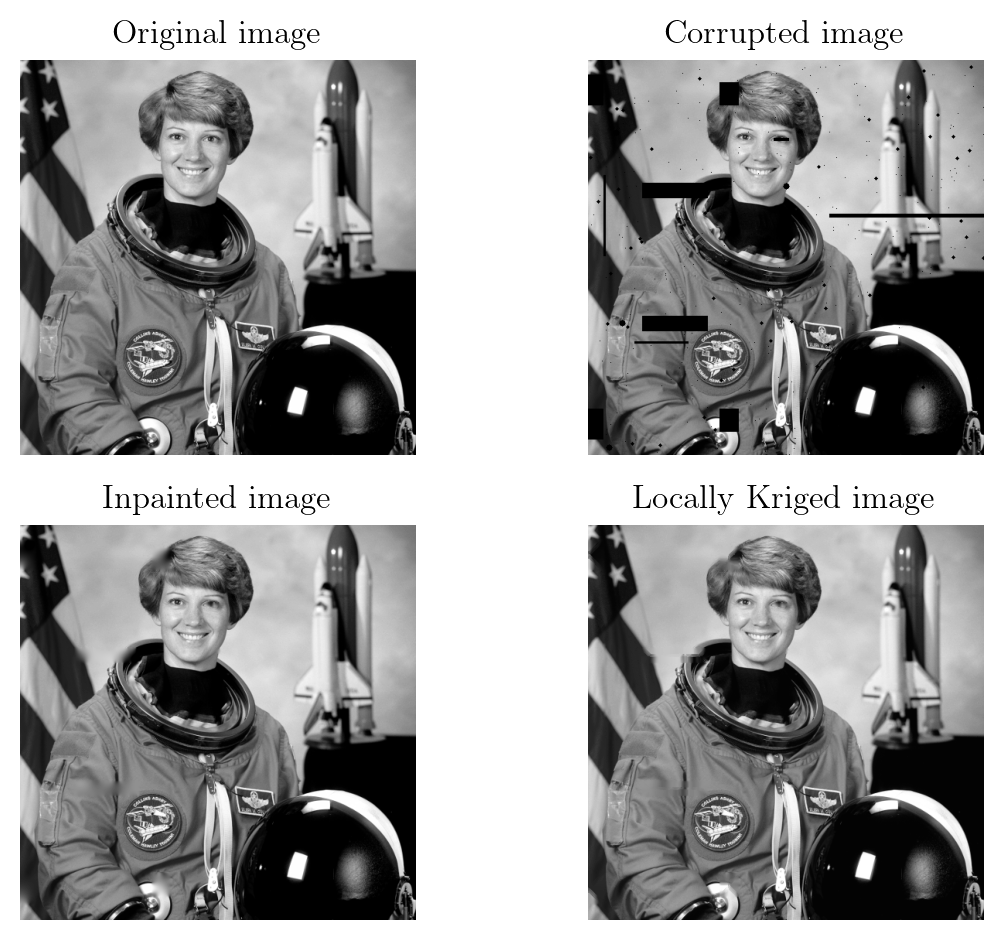

In [24]:
fig, axes = plt.subplots(ncols=2, nrows=2)
ax = axes.ravel()

ax[0].set_title('Original image')
ax[0].imshow(image_orig, cmap=plt.cm.gray)

ax[1].set_title('Corrupted image')
ax[1].imshow(image_defect, cmap=plt.cm.gray)

ax[2].set_title('Inpainted image')
ax[2].imshow(image_result, cmap=plt.cm.gray)

ax[3].set_title('Locally Kriged image')
ax[3].imshow(image_kriged_loc, cmap=plt.cm.gray)

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

In purely visual terms, local kriging is close to inpainting: some regions look better than others in the inpainted version (say, the stars on the American flag) and some look better in the kriged version (the folds on her right side where her arm touches her torso).

Both inpainting and kriging have trouble getting the collar shape correctly, but overall inpainting seems to do better at this. 

Next, let's look at the kriging error estimates. The white points are where data is unavailable because kernel training failed.  

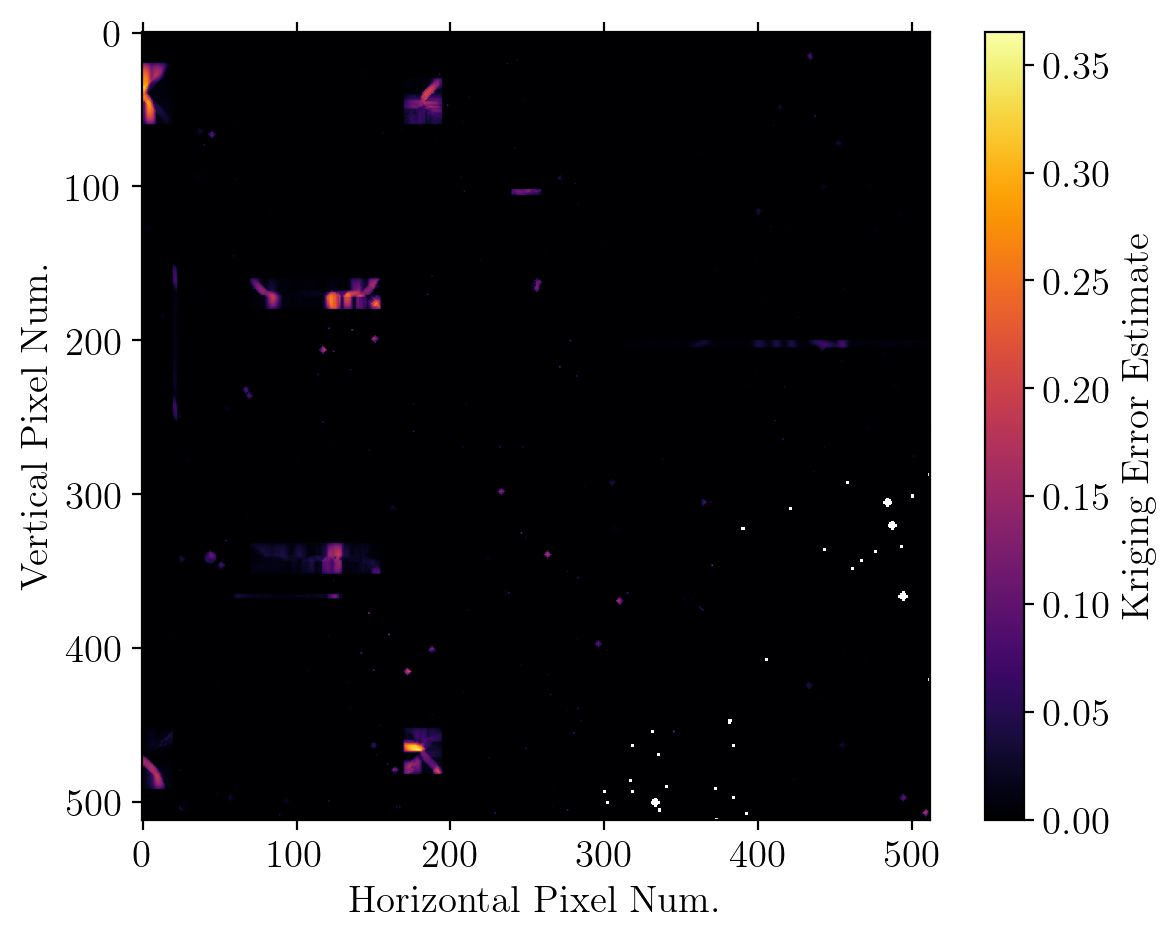

In [25]:
# plot theoretical predictions of kriging error
fig, ax = plt.subplots(ncols=1, nrows=1)

loc_kriging_error = np.zeros_like(image_orig)

std_data = np.squeeze(std_data)

cnt = 0

for pixel in pred_pixels:

    if coord_to_label(pixel) in coord_to_label(failed_pixels): # convert to labels bcz python prefers logic with scalars

        loc_kriging_error[pixel[1], pixel[0]] = None 

    else:
        std = std_data[cnt]
        loc_kriging_error[pixel[1], pixel[0]] = std
        cnt+=1

last = ax.imshow(loc_kriging_error, cmap='inferno')

plt.xlabel(r"Horizontal Pixel Num.", fontsize=14, color = textcolor)
plt.ylabel(r"Vertical Pixel Num.", fontsize=14, color=textcolor)

plt.tick_params(axis='x', which='both', top='off', color = textcolor)
plt.xticks(fontsize=14, rotation=0, color = textcolor)
plt.yticks(fontsize=14, rotation=0, color = textcolor)

cbar = plt.colorbar(last,  format='%.2f',fraction=0.046, pad=0.05)
cbar.ax.tick_params(labelsize=14, color=textcolor) 
cbar.ax.set_ylabel(r'Kriging Error Estimate', fontsize=14, color=textcolor)
cbytick_obj = plt.getp(cbar.ax.axes, 'yticklabels')                
plt.setp(cbytick_obj, color=textcolor)

fig.tight_layout()
plt.show()

Finally, we plot the actual error: 

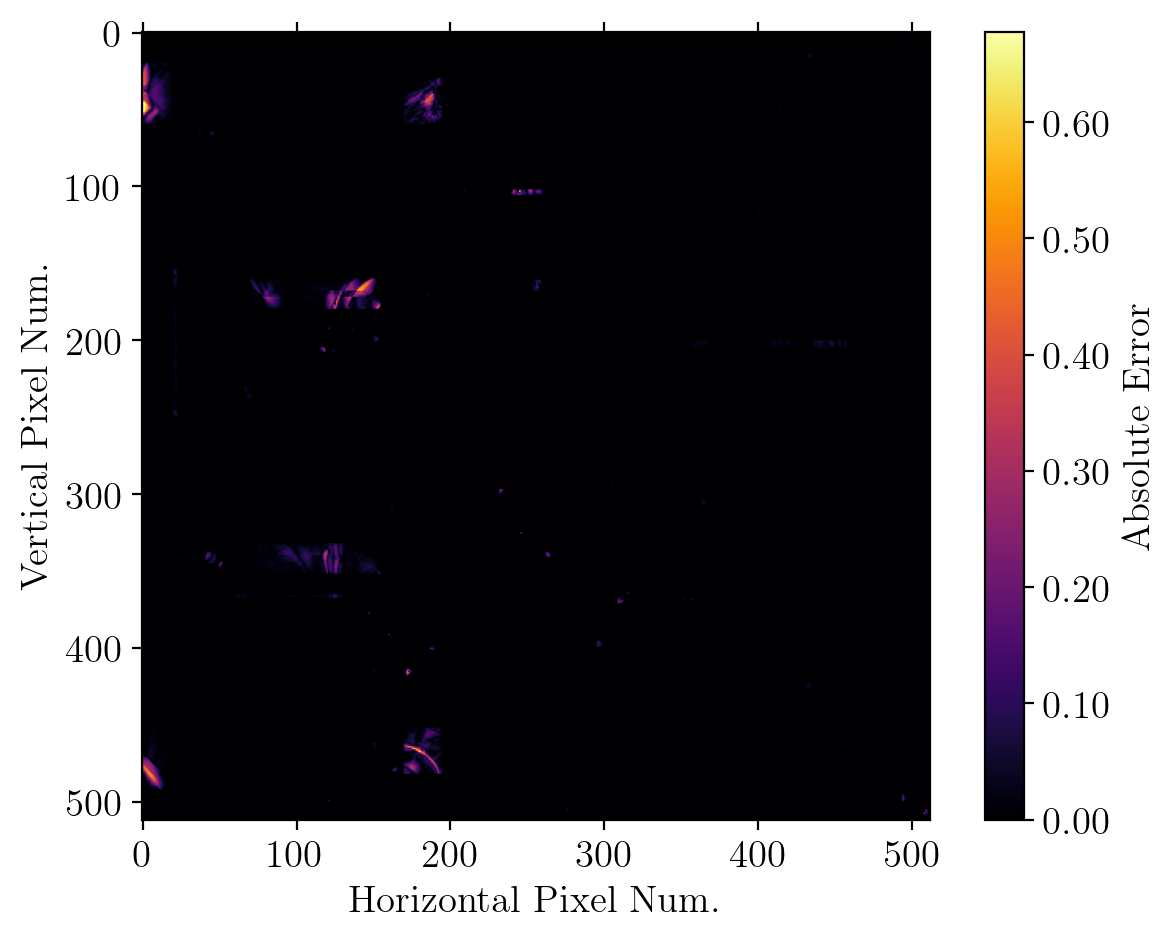

In [26]:
# plot actual kriging error
fig, ax = plt.subplots(ncols=1, nrows=1)

last = ax.imshow(np.abs(image_kriged_loc-image_orig), cmap='inferno') #, clim=(0,0.15))

plt.xlabel(r"Horizontal Pixel Num.", fontsize=14, color = textcolor)
plt.ylabel(r"Vertical Pixel Num.", fontsize=14, color=textcolor)

plt.tick_params(axis='x', which='both', top='off', color = textcolor)
plt.xticks(fontsize=14, rotation=0, color = textcolor)
plt.yticks(fontsize=14, rotation=0, color = textcolor)

cbar = plt.colorbar(last,  format='%.2f',fraction=0.046, pad=0.05)
cbar.ax.tick_params(labelsize=14, color=textcolor) 
cbar.ax.set_ylabel(r'Absolute Error', fontsize=14, color=textcolor)
cbytick_obj = plt.getp(cbar.ax.axes, 'yticklabels')                
plt.setp(cbytick_obj, color=textcolor)

fig.tight_layout()
plt.show()

Again, we find that the kriging error prediction is qualitatively similar, but generally provides an underestimate. At least, we can say that kriging automatically tells you what *regions* to trust or not trust very accurately. Though inpainting is a lot faster, it doesn't come with automatic uncertainty quantification of any kind ie. we'd have to find the "problem regions" ourselves by visual inspection. 

## Local Kriging w/ Clusters

In [27]:
# partition a list of nodes into clusters of maximum size M TODO: optimize this code, it's a lil slow, and enforce maximum size! 
def cluster_nodes(g, M = int(1e5)):
    gg = np.array(g.copy())

    cluster = []

    list_of_clusters = []

    for node in gg: 

        if node in cluster:

            pass

        else:

            eg = nx.ego_graph(pg, node, radius = int(0.5*(-1.+np.sqrt(2.*M-1)))) # round up community in the entire pixel graph

            nn = np.array(eg.nodes()) # get neighbour labels

            cluster = nn[np.isin(nn,g)] # extract neighbours that are also in g (and not gg!!!)

            gg = gg[~np.isin(gg,nn)] 

            list_of_clusters.append(cluster)

    return list_of_clusters
    

In [28]:
start=time.time()
list_of_clusters = cluster_nodes(mask_labels, M=1e1)
end=time.time()
cluster_runtime=end-start
print('time required for clustering = %.3f' % cluster_runtime, 's')

time required for clustering = 0.759 s


In [29]:
print('Number of corrupted pixels = ', len(mask_labels))
print('Number of clusters = ', len(list_of_clusters))

Number of corrupted pixels =  9425
Number of clusters =  5157


In [30]:
def get_cluster_training_data(cluster, n=12): 

    bdry = [label_to_coord(label) for label in cluster if pg.degree[label]<4] 

    if len(bdry) ==0:
        
        bdry = [label_to_coord(label) for label in cluster]
    
    X_train = np.array([[32.,32.]]) # have to do this so append works
    
    for pixel in bdry:

        nbhrs = get_good_nbhrs(pixel, n=n)

        X_train = np.concatenate((X_train, nbhrs))

    X_train_labels = np.unique(coord_to_label(X_train)[1:])

    X_train = np.array([label_to_coord(label) for label in X_train_labels])

    Y_train = np.array([image_defect[training_pixel[1], training_pixel[0]] for training_pixel in X_train])
    
    return X_train, Y_train

In [31]:
def cluster_predict(cluster, gaussian_process, n=16): # fit a kernel + predict 

    X_train, Y_train = get_cluster_training_data(cluster, n = n)

    gaussian_process.fit(X_train/512., Y_train);

    pixels_in_cluster = np.array([label_to_coord(label) for label in cluster])

    pixel_val, std = gaussian_process.predict(pixels_in_cluster, return_std=True)

    return pixel_val, std

In [118]:
from sklearn.gaussian_process.kernels import WhiteKernel

def krige_cluster(cluster, n = 16):

    kernel = 1.*Matern(length_scale_bounds=(1e-7, 1e2), nu=0.5)
    #kernel = 1.*RBF(length_scale_bounds=(1e-7, 1e2))

    gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=1, alpha=1e-1, normalize_y=True) # normalizn critical here!

    stop_flag = False 

    num_refines = 0

    max_num_refines = 1

    while stop_flag == False and num_refines <= max_num_refines:
        
        try:

            pixel_val, std = cluster_predict(cluster, gaussian_process, n=int(n*(4**num_refines)))

            stop_flag = True

        except ConvergenceWarning: 

            num_refines += 1

            pass

    if num_refines > max_num_refines: # if there's a small-scale issue that can't be fixed by adding training data,
        # just give up and really turn up the regularization & use as little training data as possible

        try: 

            reg_gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=1, alpha=1e4, normalize_y=True) # normalizn critical here!

            pixel_val, std = cluster_predict(cluster, reg_gaussian_process, n=1)

        except ConvergenceWarning: 
            
            pixel_val = None # fixing failed pixels is better done is post-processing so one can keep track of which pixels failed
                # and then handle em separately

            std = None
        
    return [pixel_val, std]

In [119]:
#warnings.resetwarnings()# kill warning error if desired
warnings.filterwarnings("error")

image_kriged_aloc = image_defect.copy()

start=time.time()

failed_clusters= []

std_data = []

#"""
for cluster in list_of_clusters:
    try: 
        out = krige_cluster(cluster, n=2)
        cnt  = 0
        pixels_in_cluster = [label_to_coord(label) for label in cluster]
        for pixel in pixels_in_cluster:
            image_kriged_aloc[pixel[1], pixel[0]] = out[0][cnt]
            std = out[1][cnt]
            std_data.append(std)
            cnt+=1
    except TypeError:
        failed_clusters.append(cluster)
#"""

end=time.time()
runtime_aloc = (end-start)/60
print('runtime=%.2f' % runtime_aloc, 'min')

runtime=0.93 min


In [120]:
# get a flattened list of the failed pixels
failed_pixel_labels = [
    x
    for xs in failed_clusters
    for x in xs
] # see the nice trick at https://stackoverflow.com/questions/952914/how-do-i-make-a-flat-list-out-of-a-list-of-lists
failed_pixels = [label_to_coord(label) for label in failed_pixel_labels]
failpercent = 100.*len(failed_pixel_labels)/len(pred_pixels)
print('fail percentage = %.3f' % failpercent, '%')

fail percentage = 0.000 %


In [121]:
#TODO: error estimates for this??? 
for pixel in failed_pixels:
    image_kriged_aloc[pixel[1], pixel[0]] = pixel_predict_mean(pixel, n=4) 

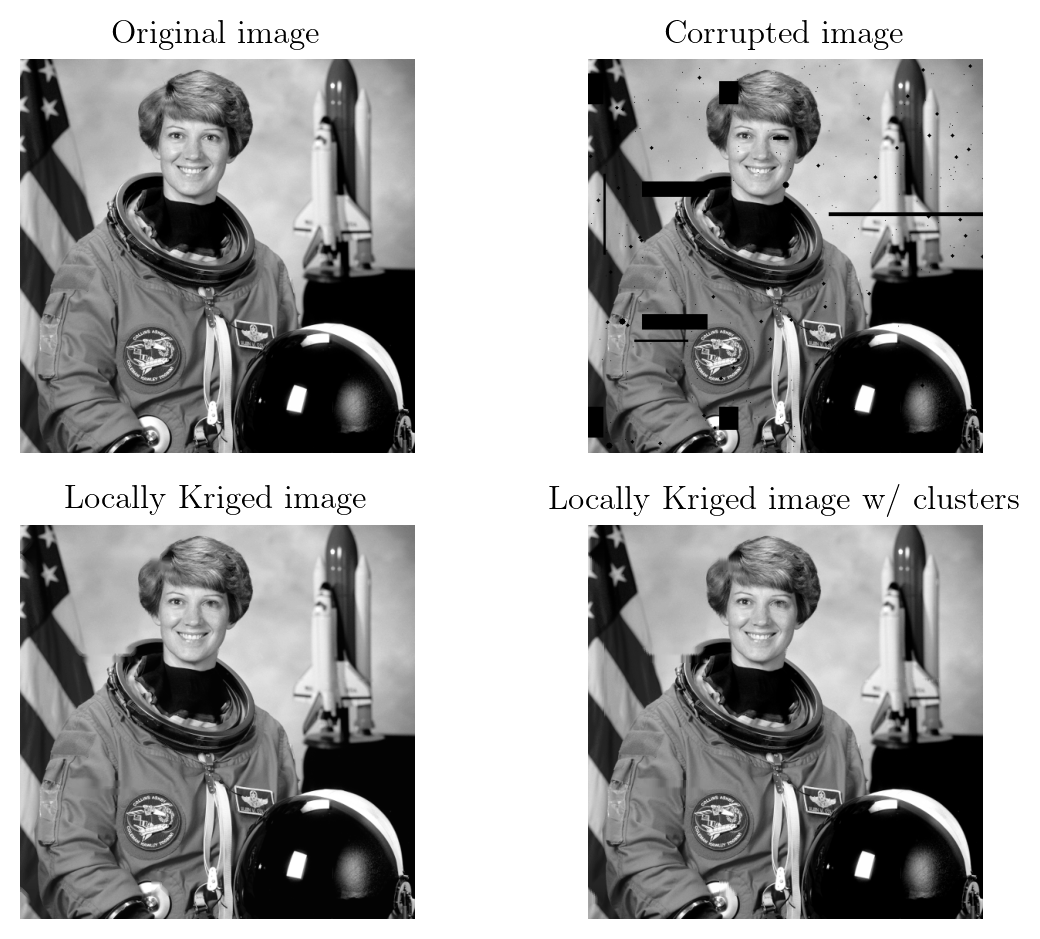

In [122]:
fig, axes = plt.subplots(ncols=2, nrows=2)
ax = axes.ravel()

ax[0].set_title('Original image')
ax[0].imshow(image_orig, cmap=plt.cm.gray)

ax[1].set_title('Corrupted image')
ax[1].imshow(image_defect, cmap=plt.cm.gray)

ax[2].set_title('Locally Kriged image')
ax[2].imshow(image_kriged_loc, cmap=plt.cm.gray)

ax[3].set_title('Locally Kriged image w/ clusters')
ax[3].imshow(image_kriged_aloc, cmap=plt.cm.gray)

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

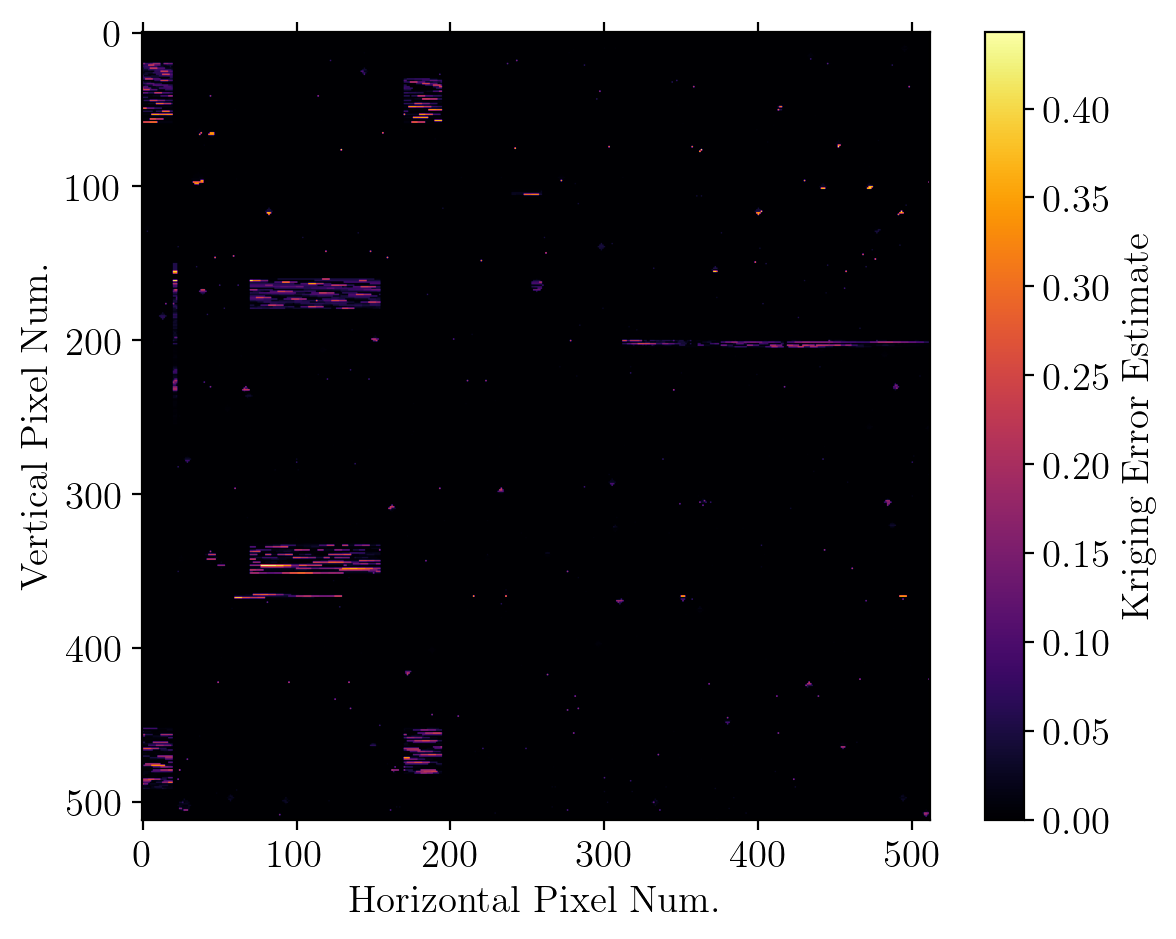

In [123]:
# plot theoretical predictions of kriging error
fig, ax = plt.subplots(ncols=1, nrows=1)

aloc_kriging_error = np.zeros_like(image_orig)

std_data = np.squeeze(std_data)

cnt = 0

for pixel in pred_pixels:

    if coord_to_label(pixel) in failed_pixel_labels: # convert to labels bcz python prefers logic with scalars

        aloc_kriging_error[pixel[1], pixel[0]] = None 

    else:
        std = std_data[cnt]
        aloc_kriging_error[pixel[1], pixel[0]] = std
        cnt+=1

last = ax.imshow(aloc_kriging_error, cmap='inferno')

plt.xlabel(r"Horizontal Pixel Num.", fontsize=14, color = textcolor)
plt.ylabel(r"Vertical Pixel Num.", fontsize=14, color=textcolor)

plt.tick_params(axis='x', which='both', top='off', color = textcolor)
plt.xticks(fontsize=14, rotation=0, color = textcolor)
plt.yticks(fontsize=14, rotation=0, color = textcolor)

cbar = plt.colorbar(last,  format='%.2f',fraction=0.046, pad=0.05)
cbar.ax.tick_params(labelsize=14, color=textcolor) 
cbar.ax.set_ylabel(r'Kriging Error Estimate', fontsize=14, color=textcolor)
cbytick_obj = plt.getp(cbar.ax.axes, 'yticklabels')                
plt.setp(cbytick_obj, color=textcolor)

fig.tight_layout()
plt.show()

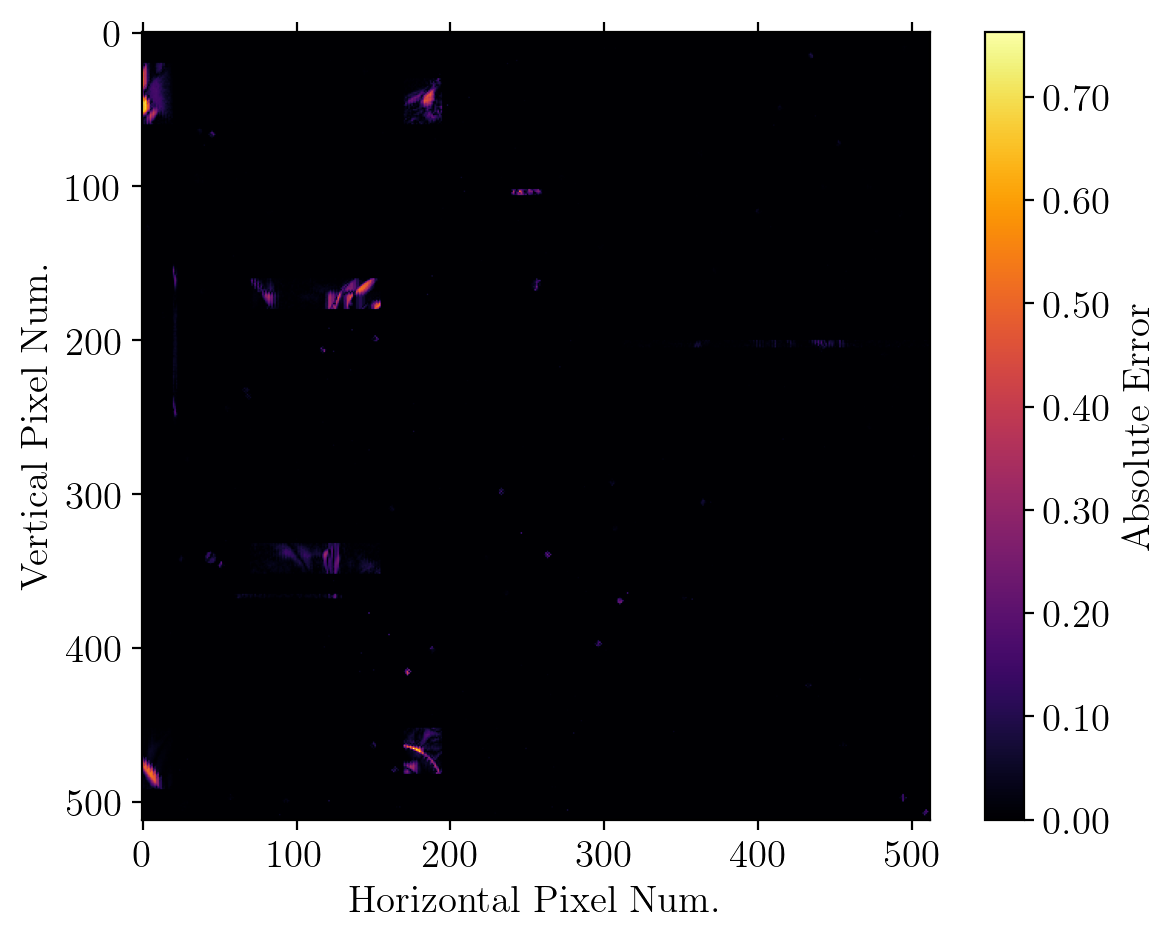

In [124]:
# plot actual kriging error
fig, ax = plt.subplots(ncols=1, nrows=1)

last = ax.imshow(np.abs(image_kriged_aloc-image_orig), cmap='inferno') #, clim=(0,0.15))

plt.xlabel(r"Horizontal Pixel Num.", fontsize=14, color = textcolor)
plt.ylabel(r"Vertical Pixel Num.", fontsize=14, color=textcolor)

plt.tick_params(axis='x', which='both', top='off', color = textcolor)
plt.xticks(fontsize=14, rotation=0, color = textcolor)
plt.yticks(fontsize=14, rotation=0, color = textcolor)

cbar = plt.colorbar(last,  format='%.2f',fraction=0.046, pad=0.05)
cbar.ax.tick_params(labelsize=14, color=textcolor) 
cbar.ax.set_ylabel(r'Absolute Error', fontsize=14, color=textcolor)
cbytick_obj = plt.getp(cbar.ax.axes, 'yticklabels')                
plt.setp(cbytick_obj, color=textcolor)

fig.tight_layout()
plt.show()

TODO: 
1) why does the kernel fit fail in pretty inconspicuous locations with little missing dots, and not in big empty chunks? This can be fixed by adding lots of regularization in desperate times, but still why does it happen and why does Tikhonov save the day? 
3) Are there any other strategies to speed up kriging? 